## Maximizing expected value flows

This notebook contains the code for the diagrams and experiments in the Paper discussing maximum expected value flows that can be used for reundant overpayments

In [1]:
from matplotlib import pyplot as plt
import numpy as np

## Situation of a remote channel

In [84]:
def success_probability(amt,capacity):
    if amt <= capacity and amt >=0:
        return (capacity+1-amt)/(capacity+1)
    return 0

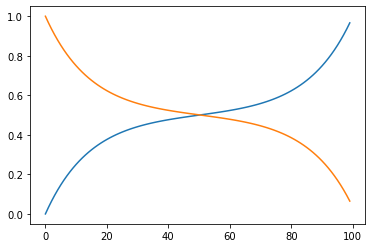

In [250]:
def bitromortac(c:float,x:float,s:float):
    ecs = 2**(-c/s)
    #print(ecs)
    exs = 2**(-x/s)
    #print(exs)
    excs = 2**((x-c)/s)
    #print(excs)
    norm = -2*ecs + 2
    #print(norm)
    return (-exs+excs)/norm + 0.5

#def bimodal_success_probability(x:float,c:float,s:float):
#    return primitive(capacity, x,s)
#"""

def primitive(x:float,c:float,s:float):
    return 2**(-x/s) + 2**((x-c)/s)

def bimodal_success_probability(x:float,c:float,s:float):
    vals = [primitive(i,c,s) for i in range(0,c+1)]
    #print(vals)
    cusum=np.cumsum(vals)
    normed = [c/cusum[-1] for c in cusum]
    #print(normed)
    return normed[int(c)-int(x)]
               
#bm =[bitromortac(100,i,10) for i in range(0,100)]
#rp =[bimodal_success_probability(i,100,10) for i in range(0,100)]

plt.plot(list(range(0,100)),bm,label="bitromortac")
plt.plot(list(range(0,100)),rp,label="rene pickhardt")
plt.show()
               
#bimodal_success_probability(10,100,10)

In [249]:
#for i in range(100):
#    print(i, bitromortac(100,i,10),bimodal_success_probability(i,100,10),success_probabilities[i])


In [243]:
capacity = 100
s = 10
amounts = [amt for amt in range(0,capacity+1)]
success_probabilities = [success_probability(amt, capacity) for amt in amounts]
expectd_sats_to_arrive = [amt*success_probability(amt,capacity) for amt in amounts]

bimodal_success_probabilities = [bimodal_success_probability(amt, capacity,s) for amt in amounts]
bimodal_expectd_sats_to_arrive = [amt*bimodal_success_probability(amt,capacity,s) for amt in amounts]

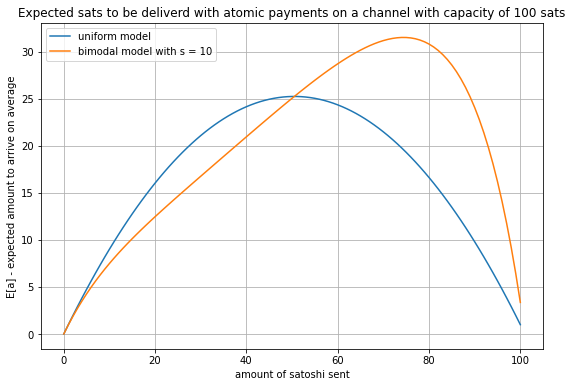

In [245]:
plt.figure(figsize=(9,6))
plt.title("Expected sats to be deliverd with atomic payments on a channel with capacity of {} sats".format(capacity))
plt.plot(amounts, expectd_sats_to_arrive,label = "uniform model")
plt.plot(amounts, bimodal_expectd_sats_to_arrive, label =  "bimodal model with s = {}".format(s))
plt.grid()
plt.xlabel("amount of satoshi sent")
plt.ylabel("E[a] - expected amount to arrive on average")
plt.legend(loc="upper left")
plt.savefig("../img/atomicPaymentSingleChannel.png")
plt.show()


In [246]:
expected_satoshis_with_optimal_sending = [x-1 for x in np.cumsum(success_probabilities)]#[amt - amt*(amt+1)/(2*(capacity+1)) for amt in amounts]
bimodal_expected_satoshis_with_optimal_sending = [x-1 for x in np.cumsum(bimodal_success_probabilities)]

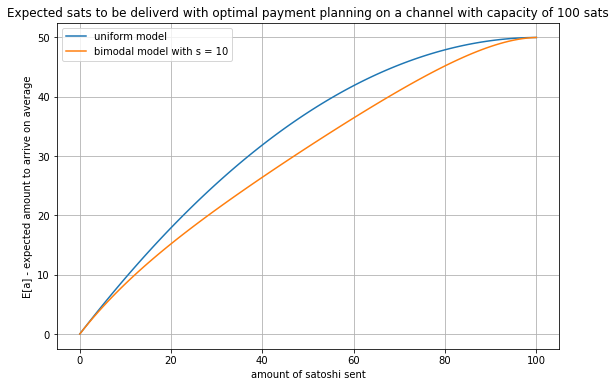

In [247]:
plt.figure(figsize=(9,6))
plt.title("Expected sats to be deliverd with optimal payment planning on a channel with capacity of {} sats".format(capacity))
plt.plot(amounts, expected_satoshis_with_optimal_sending,label = "uniform model")
plt.plot(amounts, bimodal_expected_satoshis_with_optimal_sending, label =  "bimodal model with s = {}".format(s))
plt.grid()
plt.xlabel("amount of satoshi sent")
plt.ylabel("E[a] - expected amount to arrive on average")
plt.legend(loc="upper left")
plt.savefig("../img/optimalPaymentSingleChannel.png")
plt.show()

## Example of Redundnat payment planning and ad hoc greedy MPP Splitter

need to use a for of pickhardt payment package at: https://github.com/renepickhardt/pickhardtpayments/pull/36

In [ ]:
from pickhardtpayments.ChannelGraph import ChannelGraph
from pickhardtpayments.OracleLightningNetwork import OracleLightningNetwork
from pickhardtpayments.DijkstraOverPayment import DijkstraOverPayment
from pickhardtpayments.UncertaintyNetwork import UncertaintyNetwork
from pickhardtpayments.SyncSimulatedPaymentSession import SyncSimulatedPaymentSession

import random
random.seed(3)
print("Random number with seed 3 : ", random.random()) #will generate a random number 
#if you want to use the same random number once again in your program
random.seed( 3 )
random.random()   #s


RENE = "03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df"
#Carsten Otto's public node key
C_OTTO = "027ce055380348d7812d2ae7745701c9f93e70c1adeb2657f053f91df4f2843c71"
pp_channel_graph = ChannelGraph("listchannels20220412.json")

nodes = set(pp_channel_graph.network.nodes())
len(nodes)
connected_nodes = [node for node in nodes if len(list(pp_channel_graph.network.neighbors(node))) > 9]
print(len(nodes), len(connected_nodes))

pairs = []
for i in range(100):
    src, dest = random.sample(connected_nodes,2)
    if src != dest:
        pairs.append((src,dest,random.randint(500_000,5_000_000)))

        
oracle_lightning_network = OracleLightningNetwork(pp_channel_graph)
uncertainty_network = UncertaintyNetwork(pp_channel_graph)
payment_session = SyncSimulatedPaymentSession(oracle_lightning_network, 
                                 uncertainty_network,
                                 prune_network=False)

#payment_session.forget_information()
for src, dest, amt in pairs:
    amt = oracle_lightning_network.theoretical_maximum_payable_amount(src,dest)/5
    #print(src,dest, amt)
    if amt ==0: 
        continue
    payment_session.forget_information()
    payment_session.pickhardt_pay( src, dest, amt,mu=0,base=0,redundant_over_payment=True)
    oracle_lightning_network = OracleLightningNetwork(pp_channel_graph)